In [6]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

from test_utils import *

In [8]:
with open('results.pkl','rb') as infile:
    rawData = pickle.load(infile)

In [52]:
rawDataCSVString = "PDBid,ChainID,Res#,WT,MUT,pH,T,ddT_exp,ddG_exp,ddG_pred,RSA"
rawDataCSVString += '\n'.join([ x.to_csv_row() for x in rawData if x is not None ])
rDCSVSIO = StringIO(rawDataCSVString)
rawDataCSV = pd.read_csv(rDCSVSIO)
thermoData = rawDataCSV[['PDBid','ddG_exp','ddG_pred']]

# Drop values with no existing ddG experimental measure
thermoData = pd.DataFrame(thermoData.mask(thermoData.eq('None')).dropna())

# Modify the data
thermoData['ddG_exp']=thermoData['ddG_exp'].astype(np.float)
thermoData['ddG_pred']=-thermoData['ddG_pred']

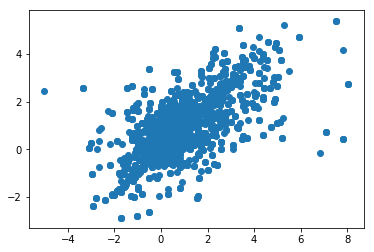

In [67]:
# Sanity Check
plt.scatter(thermoData['ddG_exp'], thermoData['ddG_pred'])
plt.show()

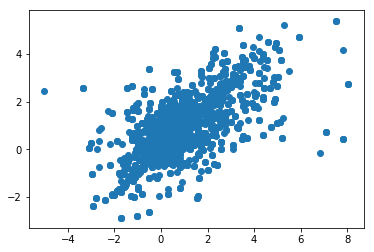

In [105]:
expSigThreshold = "-0.5"

def filterPrediction(dframe, threshold):
    return dframe.query('ddG_pred < '+str(threshold))

def posNegCount(dframe):
    miss = len(dframe.query('ddG_exp > ' + expSigThreshold))
    hit = len(dframe.query('ddG_exp < ' + expSigThreshold))
    return (pos,neg)

In [106]:
predThreshold = np.linspace(-2.0,0.5,100)

predOutcomes = [filterPrediction(thermoData,x) for x in predThreshold]

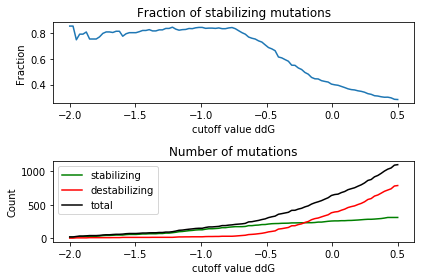

In [107]:
predPNCount = [posNegCount(df) for df in predOutcomes]

output = []
for (thresh, (miss,hit)) in zip(predThreshold, predPNCount):
    output.append([thresh, miss, hit])

pinf = pd.DataFrame(output, columns=['cutoff','destabil','stabil'])

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.set_xlabel("cutoff value ddG")
ax1.set_ylabel("Fraction")
ax1.set_title("Fraction of stabilizing mutations")
ax1.plot(pinf['cutoff'], pinf.stabil / (pinf.destabil + pinf.stabil))

ax2.set_xlabel("cutoff value ddG")
ax2.set_ylabel("Count")
ax2.set_title("Number of mutations")

ax2.plot(pinf.cutoff, pinf.stabil, c='green')
ax2.plot(pinf.cutoff, pinf.destabil, c='red')
ax2.plot(pinf.cutoff, pinf.destabil + pinf.stabil, c='black')
ax2.legend(['stabilizing', 'destabilizing', 'total'])

plt.tight_layout()
plt.show()